In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lmfit
from lmfit import  Model, Parameters

In [2]:
def new_vitesse(x, dir_target, start_anti, v_anti, latence, maxi, ramp_pursuit, do_whitening) :

    v_anti = v_anti/1000 # to switch from sec to ms
    ramp_pursuit = ramp_pursuit/1000
    time = x
    vitesse = []
    y = 0
    end_ramp_pursuit = ((dir_target*maxi)/ramp_pursuit) + latence
    
    for t in range(len(time)):
        
        if start_anti >= latence :
            
            if time[t] < latence :
                vitesse.append(0)
            else :
                if latence >= end_ramp_pursuit :
                    vitesse.append(dir_target*maxi)
                else :
                    if time[t] < end_ramp_pursuit : vitesse.append((time[t]-latence)*ramp_pursuit)
                    else :                vitesse.append(dir_target*maxi)
        
        #-------------------------------------------------------------------------------
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append((time[t]-start_anti)*v_anti)
                    y = (time[t]-start_anti)*v_anti
                else :
                    if latence >= end_ramp_pursuit :
                        vitesse.append(dir_target*maxi)
                    else :
                        if time[t] < int(end_ramp_pursuit) : vitesse.append((time[t]-latence)*ramp_pursuit+y)
                        else :                vitesse.append(dir_target*maxi+y)
        

    return vitesse

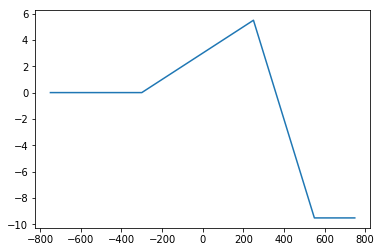

In [3]:
time = np.arange(-750, 750)
vivi = new_vitesse(time, -1, -300, 10, 250, 15, -50, False)
plt.plot(time, vivi);

In [4]:
import pickle
with open('result/param_Fit_AM_fct_velocity_2_step_False_whitening.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
    
datafile = 'data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [5]:
A = ANEMO(exp)
Plot = ANEMO.Plot(exp)

/usr/local/lib/python3.5/dist-packages/ANEMO-0.0.1-py3.5.egg/ANEMO/ANEMO.py:661: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/ANEMO-0.0.1-py3.5.egg/ANEMO/ANEMO.py:682: RuntimeWarning: Mean of empty slice


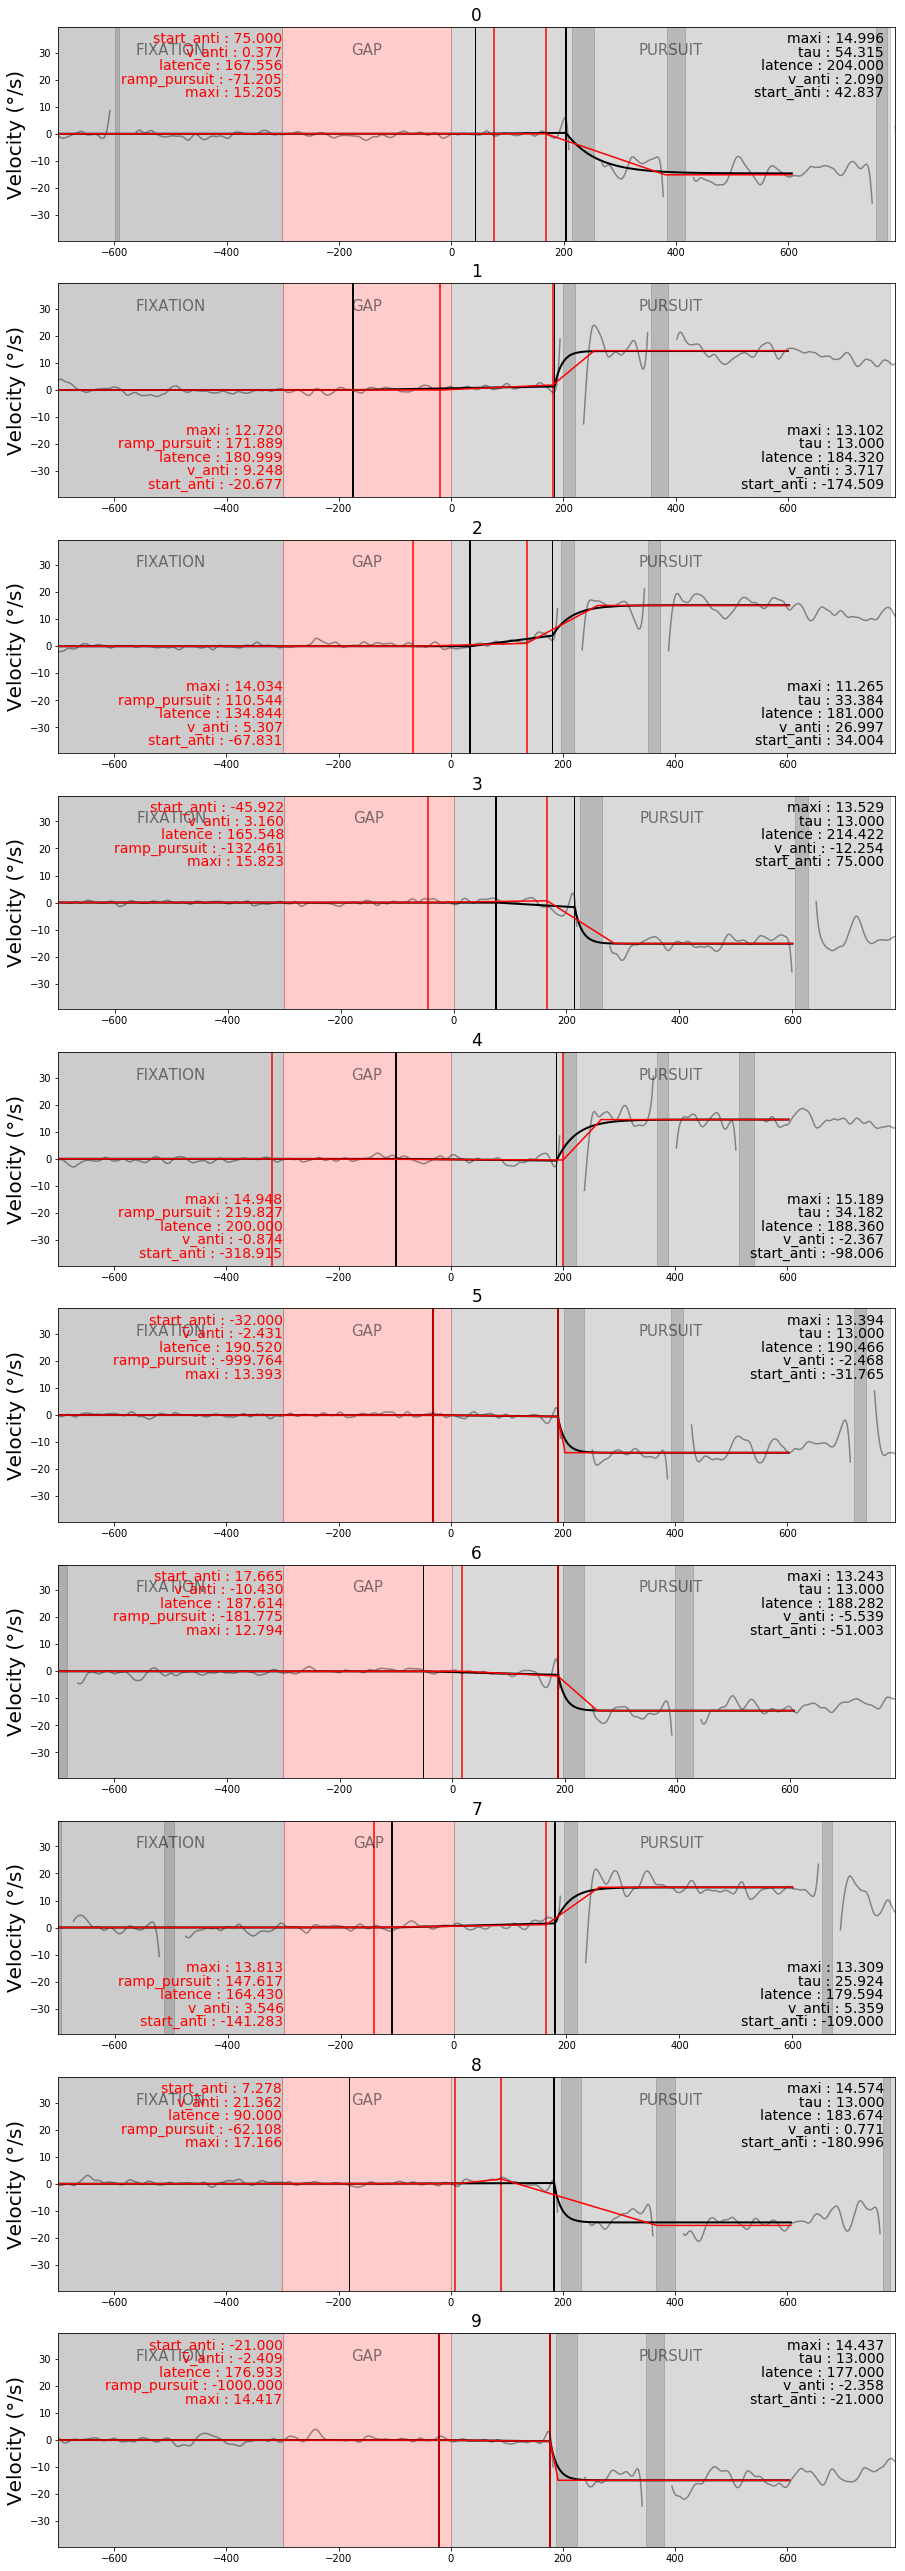

In [6]:
nb_trial = 10
fig, axs = plt.subplots(nb_trial, 1, figsize=(15, (15*(nb_trial/2))/1.6180))

block = 0
for trial in range(nb_trial) :
    
    ax=axs[trial]
    
    time_sup = 280

    trial_data = trial + exp['N_trials']*block
    arg = A.arg(data[trial_data], trial=trial, block=block)
    
    velocity_NAN = A.velocity_NAN(**arg, filt='velocity')[0]

    data_trial = velocity_NAN[:-time_sup]
    trackertime = arg.trackertime[:-time_sup]

    model = Model(new_vitesse)

    max_latence = []
    for s in range(len(arg.saccades)) :
        if (arg.saccades[s][0]-arg.t_0) >= (arg.TargetOn-arg.t_0+100) :
            max_latence.append((arg.saccades[s][0]-arg.t_0))
    if max_latence == [] :
        max_latence.append(len(trackertime))
    max_latence = max_latence[0]

    value_latence, value_maxi, value_anti = A.classical_method.Full(data_trial, arg.TargetOn)
    
    if np.isnan(value_latence): value_latence= arg.TargetOn-arg.t_0+100
    if np.isnan(value_anti): value_anti= 0.
    if np.isnan(value_maxi): value_maxi= 15.


    if value_latence >= max_latence-50 : value_latence = max_latence-150
    if value_latence > 250 :             value_latence = arg.TargetOn-arg.t_0+100


    vary = False

    param_fit=[{'name':'ramp_pursuit', 'value':50*arg.dir_target,   'min':40*arg.dir_target,
                'max':1000*arg.dir_target, 'vary':'vary'},
               {'name':'maxi', 'value':value_maxi,           'min':1.,
                'max':40.,               'vary':True  },
               {'name':'dir_target', 'value':arg.dir_target, 'min':None,
                'max':None,              'vary':False },
               {'name':'v_anti',     'value':value_anti,     'min':-40.,
                'max':40.,               'vary':True  },
               {'name':'latence',    'value':value_latence,  'min':arg.TargetOn-arg.t_0+75,
                'max':max_latence,       'vary':True  },
               {'name':'start_anti', 'value':arg.TargetOn-arg.t_0-100, 'min':arg.StimulusOf-arg.t_0-200,
                'max':arg.TargetOn-arg.t_0+75, 'vary':'vary'}]

    inde_vars={'x':np.arange(len(trackertime))}

    equation = new_vitesse
    params = Parameters()
    model = Model(equation, independent_vars=inde_vars.keys())

    for num_par in range(len(param_fit)) :
        if param_fit[num_par]['vary'] == 'vary' : var = vary
        else :                                    var = param_fit[num_par]['vary']
        params.add(param_fit[num_par]['name'],
                   value=param_fit[num_par]['value'],
                   min=param_fit[num_par]['min'],
                   max=param_fit[num_par]['max'],
                   vary=var)

    params.add('do_whitening', value=False, vary=False)

    out = model.fit(data_trial, params, nan_policy='omit', **inde_vars)

    # make the other parameters vary now
    for num_par in range(len(param_fit)) :
        if param_fit[num_par]['vary'] == 'vary' :
            out.params[param_fit[num_par]['name']].set(vary=True)

    result_deg = model.fit(data_trial, out.params, method='nelder', nan_policy='omit', **inde_vars)

    #------------------------------------------------------------------------------------------------
    time = arg.trackertime[:-time_sup]-arg.TargetOn
    onset = arg.TargetOn - arg.t_0


    ax = Plot.generate_fig(ax, data, trial, block, show='fit', fig=fig, filt='velocity', **arg)

    ax.plot(time, new_vitesse(np.arange(len(arg.trackertime[:-time_sup])), **result_deg.values), c='r')
    ax.vlines(result_deg.values['start_anti']-onset, -40, 40, colors='r')
    ax.vlines(result_deg.values['latence']-onset, -40, 40, colors='r')

    list_param = ['start_anti', 'v_anti', 'latence', 'ramp_pursuit', 'maxi']

    param_fit = {}
    for name in result_deg.values.keys() :
        if name in ['latence', 'start_anti'] : param_fit[name] = result_deg.values[name]-onset
        else : param_fit[name] = result_deg.values[name]

    ax.set_title(trial, fontsize=17)
    ax.set_xlabel('')
    x = 0
    for name in list_param :
        ax.text(arg.StimulusOf-arg.TargetOn, -arg.dir_target*35+(-arg.dir_target*x),
                "%s : %0.3f"%(name, param_fit[name]) , color='r', size=14, va='center', ha='right')
        x = x - 5